In [2]:
import os

In [3]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
sales=pd.read_csv("https://raw.githubusercontent.com/TSS-sniper/Dataset/main/train.csv")
sales.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


Check for Null values in the table

In [5]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [6]:
sales=sales.drop(['store','item'], axis=1)

In [7]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   sales   913000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB


Converting Date from obj datatype to DateTime Datatype

In [8]:
sales['date']=pd.to_datetime(sales['date'])

In [9]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


Converting Date to a month period and then sum the number of the items in each month

In [10]:
sales['date']=sales['date'].dt.to_period("M")
monthly_sales=sales.groupby('date').sum().reset_index()

Convert the Resulting date column to timestamp datatype

In [11]:
monthly_sales['date']=monthly_sales['date'].dt.to_timestamp()

In [12]:
monthly_sales.head(50)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


Visualization

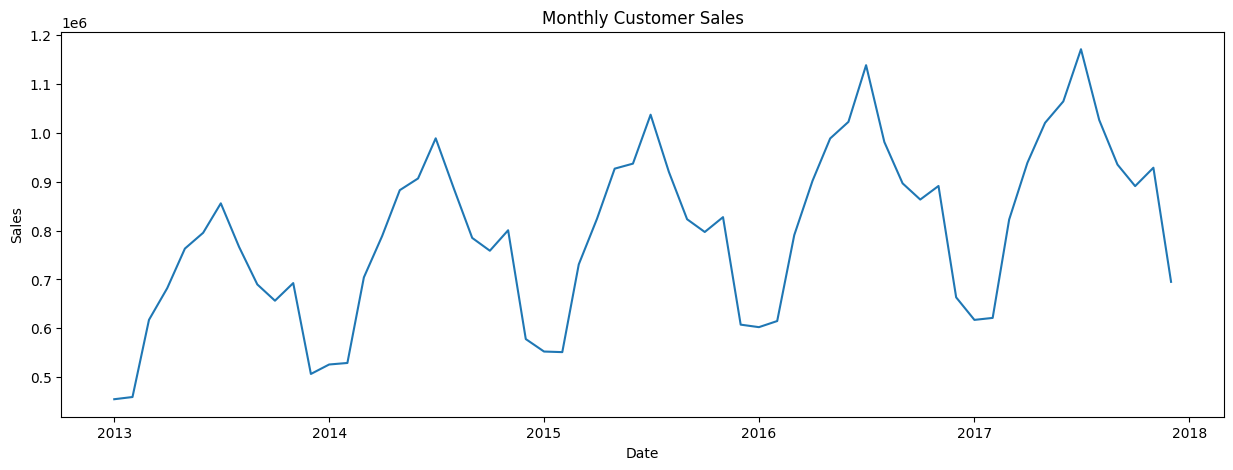

In [21]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Customer Sales")
plt.show()

Call the difference on the sales columns to make the sales data stationary

In [23]:
monthly_sales['sales_diff']=monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head()

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0


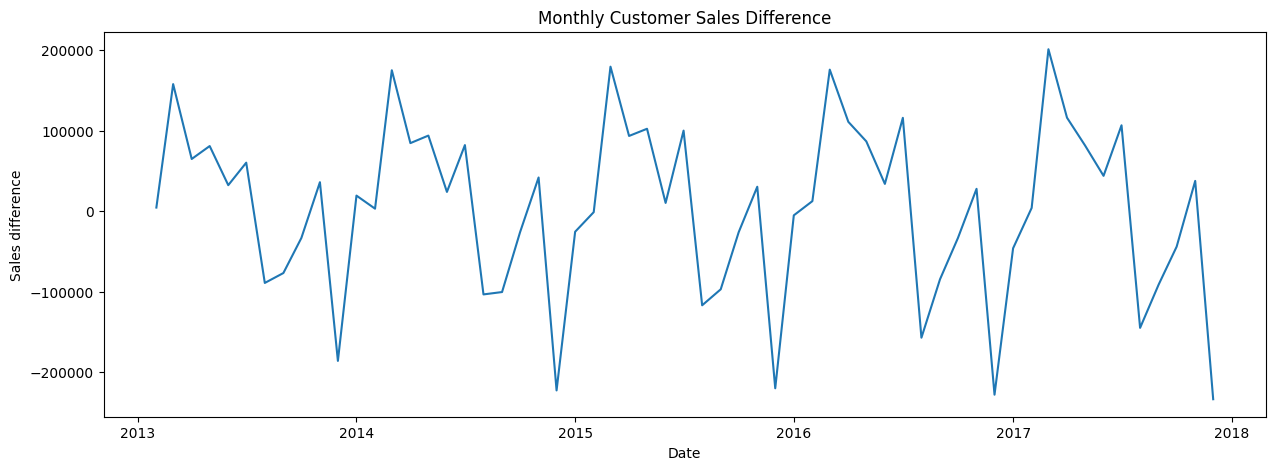

In [25]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales_diff'])
plt.xlabel("Date")
plt.ylabel("Sales difference")
plt.title("Monthly Customer Sales Difference")
plt.show()

Dropping off Sales and Date

In [27]:
supervised_data=monthly_sales.drop(['date','sales'],axis=1)

Preparing the Supervised Data

In [29]:
for i in range(1,13):
  col_name='month_' + str(i)
  supervised_data[col_name]= supervised_data['sales_diff'].shift(i)
supervised_data= supervised_data.dropna().reset_index(drop=True)
supervised_data.head(5)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,-1196.0,-25535.0,-222735.0,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0
1,179634.0,-1196.0,-25535.0,-222735.0,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0
2,93516.0,179634.0,-1196.0,-25535.0,-222735.0,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0
3,102435.0,93516.0,179634.0,-1196.0,-25535.0,-222735.0,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0
4,10282.0,102435.0,93516.0,179634.0,-1196.0,-25535.0,-222735.0,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0


Splitting the Data into Training and Test Dataset

In [30]:
train_data=supervised_data[:-12]
test_data=supervised_data[-12:]
print("Train Data Shape: ", train_data.shape)
print("Test Data Shape: ", test_data.shape)

Train Data Shape:  (23, 13)
Test Data Shape:  (12, 13)


In [31]:
scaler=MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data=scaler.transform(train_data)
test_data=scaler.transform(test_data)

In [33]:
X_train,y_train=train_data[:,1:], train_data[:,0:1]
X_test,y_test=test_data[:,1:], test_data[:,0:1]
y_train=y_train.ravel()
y_test=y_test.ravel()
print("X_train Shape: ", X_train.shape)
print("y_train Shape: ", y_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (23, 12)
y_train Shape:  (23,)
X_test Shape:  (12, 12)
y_test Shape:  (12,)


Create Prediction Data frame to merge the predicted sales prices of all trained algs

In [35]:
sales_dates=monthly_sales['date'][-12:].reset_index(drop=True)
predict_df= pd.DataFrame(sales_dates)

In [36]:
act_sales= monthly_sales['sales'][-13:].to_list()
print(act_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


Create the Linear Regression Model and predicted output

In [37]:
lr_model=LinearRegression()
lr_model.fit(X_train,y_train)
lr_pre=lr_model.predict(X_test)

In [38]:
lr_pre=lr_pre.reshape(-1,1)
#Its a set Matrix
lr_pre_test=np.concatenate([lr_pre, X_test],axis=1)
lr_pre_test=scaler.inverse_transform(lr_pre_test)

In [39]:
result_list=[]
for index in range(0,len(lr_pre_test)):
   result_list.append(lr_pre_test[index][0] + act_sales[index])
lr_pre_series=pd.Series(result_list, name="Linear Prediction")
predict_df = predict_df.merge(lr_pre_series, left_index=True,right_index=True)

In [41]:
lr_mse= np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:]))
lr_mae= mean_absolute_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
lr_r2= r2_score(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])

print("Linear Regression MSE: ",lr_mse)
print("Linear Regression MAE: ",lr_mae)
print("Linear Regression R2: ",lr_r2)

Linear Regression MSE:  22043.446890266434
Linear Regression MAE:  16028.038328796052
Linear Regression R2:  0.9813541328509165


Visualization of the prediction against the actual sales

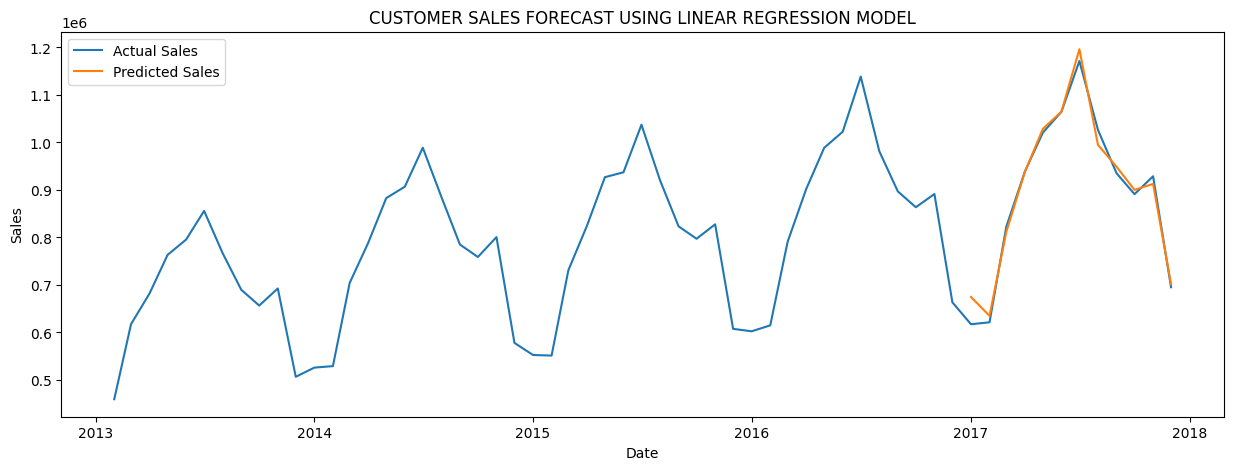

In [45]:
plt.figure(figsize=(15,5))
# Actual Sales
plt.plot(monthly_sales['date'], monthly_sales['sales'])
# Predicted Sales
plt.plot(predict_df['date'],predict_df['Linear Prediction'])
plt.title("CUSTOMER SALES FORECAST USING LINEAR REGRESSION MODEL")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(['Actual Sales', 'Predicted Sales'])
plt.show()